![example](images/director_shot.jpeg)

# Project Hollywood

**Authors:** Arthur Kim, Mia Fryer, Eddie Lin, Ian Sharff

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding
***

The data was obtained from five sources (IMDb, TMDb, Rotten Tomatoes, The Numbers, and Box Office Mojo) and delivered in CSV format. We were tasked with analyzing this data and determining three actionable recommendations for a company that wishes to begin a new venture in the movie-making industry. With an understanding of the requirements, we then began taking a deep dive into the 1 CSV/TSV files to see how we could connect each dataset and generate aggregated data.

![graph](./images/Project_Hollywood_Schemas_v2.png)

In the above schema, shaded items indicate matching keys according to color. While the blue, yellow and green items represent matching keys, the "modified_name" key was constructed by stripping movie names of punctuation and whitespace so that title matching between datasets lacking predifined keys could return more matches.

### Existing Keys
- IMDB
    - 'tconst': identifies a unique movie
    - 'nconst': identifies a unique individual (cast/crew/directors/writers/etc.)
    - 'title_id': corresponds to 'tconst' in the imdb.title.akas.csv dataset
- TMDB
    - 'genre_ids': lists of id's corresponding to genre, which were obtained via the TMDB API
- Rotten Tomatoes:
    - 'id': ideintifies a unique movie, but limited to the two Rotten Tomatoes TSV files

### Features of Interest
* Movie titles
* Genres
* Content rating
* User and critic review sentiment
* Influencial cast and producers
* Production Budget
* Domestic and foreign gross profit

### Source-Specific features

- Rotten Tomatoes
    - 'fresh': overall review sentiment, either "fresh" or "rotten"
    - 'rating': the movie's content rating (G, PG, PG-13, R, NR)
    - 'genre': genre classification(s) pertaining to a given movie
- IMDB
    - 'primary-profession', 'directors', 'writers': identify an individual's role in movie production
    - 'genres': genre classification, slightly different from Rotten Tomatoes classifications
- TMDB
    - 'genre_ids': genre classifications as integers, requiring a mapping of key to genre as a string
    - 'popularity', 'vote_count': indicators of viewer sentiment
- The Numbers
    - 'production_budget': production expenditure limit for a given film
    - 'domestic_gross', 'worldwide_gross': financial metrics on a movie's box office performance
- Box Office Mojo
    - 'domestic_gross', 'foreign_gross': financial metrics for a different set of movies, increasing available sample size

These were explored using the pandas library to determine the quality of data in each file and to determine a course of action for cleaning. Example information from each source is provided below

***

## Data Preparation

***

In general, each file was cleaned prior to being joined with another. In some cases this was not necessary, given that much of the data was already in a suitable format. However, in many cases, it was reasonable to remove unnecessary variables prior to merging. Some sample cases are highlighted below and the remaining cleaning processes are documented in the [tools/data_preparation.py](tools/data_preparation.py) module.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Here, we import the data_preparation module from the tools package which contains functions for cleaning and merging the datasets. The cleaned data will be demonstrated and compared to the raw data from the CSV. 

In [2]:
import tools.data_preparation as dp

The contents of the data directory are shown below:

In [3]:
!ls data

bom.movie_gross.csv       imdb.title.crew.csv       rt.reviews.tsv
imdb.name.basics.csv      imdb.title.principals.csv tmdb.movies.csv
imdb.title.akas.csv       imdb.title.ratings.csv    tmdb_genre_ids.json
imdb.title.basics.csv     rt.movie_info.tsv         tn.movie_budgets.csv


### Rotten Tomatoes Dataset

***

Both files from the Rotten Tomatoes dataset contained superfluous values that we did not apply to our analysis. For example, the original rt.reviews.tsv file has these properties:

In [4]:
original_rt_reviews = pd.read_csv('./data/rt.reviews.tsv', encoding='latin-1', delimiter='\t')
original_rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [5]:
original_rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [6]:
# Helper function for displaying percent NaN values
dp.display_percent_nan(original_rt_reviews)

id: 0.00 % null
review: 10.22 % null
rating: 24.83 % null
fresh: 0.00 % null
critic: 5.00 % null
top_critic: 0.00 % null
publisher: 0.57 % null
date: 0.00 % null


Of these features, the critic and publisher information were immediately discarded because we decided that they did not convey significant information that could be aggregated. The rating column, (here denoting the reviewer's overall rating of the film rather than the content rating) was also discarded, given that there was no uniformity in the rating scales. Roughly 25% were null values, while the remaining values were in widely different formats:

In [7]:
print(*original_rt_reviews['rating'].unique(), sep=', ')

3/5, nan, C, 2/5, B-, 2/4, B, 3/4, 4/5, 4/4, 6/10, 1/4, 8, 2.5/4, 4/10, 2.0/5, 3/10, 7/10, A-, 5/5, F, 3.5/4, D+, 1.5/4, 3.5/5, 8/10, B+, 9/10, 2.5/5, 7.5/10, 5.5/10, C-, 1.5/5, 1/5, 5/10, C+, 0/5, 6, 0.5/4, D, 3.1/5, 3/6, 4.5/5, 0/4, 2/10, D-, 7, 1/10, 3, A+, A, 4.0/4, 9.5/10, 2.5, 2.1/2, 6.5/10, 3.7/5, 8.4/10, 9, 1, 7.2/10, 2.2/5, 0.5/10, 5, 0, 2, 4.5, 7.7, 5.0/5, 8.5/10, 3.0/5, 0.5/5, 1.5/10, 3.0/4, 2.3/10, 4.5/10, 4/6, 3.5, 8.6/10, 6/8, 2.0/4, 2.7, 4.2/10, 5.8, 4, 7.1/10, 5/4, N, 3.5/10, 5.8/10, R, 4.0/5, 0/10, 5.0/10, 5.9/10, 2.4/5, 1.9/5, 4.9, 7.4/10, 1.5, 2.3/4, 8.8/10, 4.0/10, 2.2, 3.8/10, 6.8/10, 7.3, 7.0/10, 3.2, 4.2, 8.4, 5.5/5, 6.3/10, 7.6/10, 8.1/10, 3.6/5, 2/6, 7.7/10, 1.8, 8.9/10, 8.9, 8.2/10, 8.3/10, 2.6/6, 4.1/10, 2.5/10, F+, 6.0/10, 1.0/4, 7.9/10, 8.7/10, 4.3/10, 9.6/10, 9.0/10, 4.0, 1.7, 7.9, 6.7, 8.0/10, 9.2/10, 5.2, 5.9, 3.7, 4.7, 6.2/10, 1/6, 8.2, 2.6/5, 3.4, 9.7, 3.3/5, 3.8/5, 1/2, 7.4, 4.8, 1.6/5, 2/2, 1-5, 1.0, 4.3/5, 5/6, 9.2, 2.7/5, 4.9/10, 3.0, 3.1, 7.8/10, 

While these could have been parsed and scaled to numeric values, we found it suitable to use the 'fresh' column, which contained no NaN values. The values of 'fresh' and 'rotten' were converted to 1 and 0 respectively so that a tally of positive reviews could be assembled. A highlight of the cleaned file is shown below with empty review values being filled with the string 'Empty' (controlled with the 'na_action' parameter with the default being None and 'drop' removing rows with NaN reviews).

In [8]:
clean_reviews = dp.clean_rt_reviews(na_action='fill')
clean_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54423 entries, 0 to 54431
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          54423 non-null  int64         
 1   review      54423 non-null  object        
 2   fresh       54423 non-null  int64         
 3   top_critic  54423 non-null  int64         
 4   date        54423 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.5+ MB


In [9]:
clean_reviews.head()

,id,review,fresh,top_critic,date
0,3,A distinctly gallows take on contemporary fina...,1,0,2018-11-10
1,3,It's an allegory in search of a meaning that n...,0,0,2018-05-23
2,3,... life lived in a bubble in financial dealin...,1,0,2018-01-04
3,3,Continuing along a line introduced in last yea...,1,0,2017-11-16
4,3,... a perverse twist on neorealism...,1,0,2017-10-12


In [10]:
dp.display_percent_nan(clean_reviews)

id: 0.00 % null
review: 0.00 % null
fresh: 0.00 % null
top_critic: 0.00 % null
date: 0.00 % null


The Rotten Tomatoes movie information file (rt.movie_info.tsv) was cleaned by dropping columns other than the synopsis, movie title, and genres columns. The genres feature for the most part contained two or more genres per movie, which necessitated them being split into a sequential datatype (tuple in this case) and then 'exploded' into long format. Parameters also allow for NaN rows to be dropped in a given subset.

In [11]:
clean_movie_info = dp.clean_rt_movie_info()
clean_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1560 non-null   int64         
 1   synopsis      1498 non-null   object        
 2   rating        1557 non-null   object        
 3   genre         1560 non-null   object        
 4   theater_date  1201 non-null   datetime64[ns]
 5   dvd_date      1201 non-null   datetime64[ns]
 6   runtime       1530 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 85.4+ KB


In [12]:
clean_movie_info.head()

,id,synopsis,rating,genre,theater_date,dvd_date,runtime
0,1,"This gritty, fast-paced, and innovative police...",R,"(Action and Adventure, Classics, Drama)",1971-10-09,2001-09-25,104.0
1,3,"New York City, not-too-distant-future: Eric Pa...",R,"(Drama, Science Fiction and Fantasy)",2012-08-17,2013-01-01,108.0
2,5,Illeana Douglas delivers a superb performance ...,R,"(Drama, Musical and Performing Arts)",1996-09-13,2000-04-18,116.0
3,6,Michael Douglas runs afoul of a treacherous su...,R,"(Drama, Mystery and Suspense)",1994-12-09,1997-08-27,128.0
4,7,NaN,NR,"(Drama, Romance)",NaT,NaT,200.0


These two sets were merged with the following function which can output either the full dataframe, or subsets specific to genre and rating popularity to be used in modelling.

In [13]:
rt_genre_popularity = dp.merge_rt_data(focus='genre_popularity')
rt_rating_popularity = dp.merge_rt_data(focus='rating_popularity')

In [14]:
display(rt_genre_popularity, rt_rating_popularity)

,total_references,total_positive,percent_positive
genre,,,
Drama,33595,21942,0.653133
Comedy,21798,12878,0.590788
Action and Adventure,12908,7334,0.568175
Mystery and Suspense,11742,6874,0.585420
Romance,8088,5168,0.638971
Science Fiction and Fantasy,7363,4030,0.547331
Art House and International,4519,3427,0.758354
Kids and Family,4609,2864,0.621393
Horror,4283,1994,0.465562


,total_references,total_positive,percent_positive
rating,,,
R,24367,15559,0.638528
PG-13,18003,9302,0.516692
PG,8246,5286,0.641038
NR,2650,2045,0.771698
G,1071,774,0.722689


### IMDB x Box Office Mojo
***

Data on average total gross in USD (also scaled by 10 ^ -5 for plotting purposes) was prepared in a similar manner, keeping only data pertinent to the comparison between genre and gross profits

In [15]:
genre_to_gross = dp.merge_bom_and_imdb()
genre_to_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres                22 non-null     object 
 1   numvotes              22 non-null     int64  
 2   avgrating_x_numvotes  22 non-null     float64
 3   avgnumvotes           22 non-null     float64
 4   domestic_gross        22 non-null     float64
 5   foreign_gross         22 non-null     float64
 6   total_gross           22 non-null     float64
 7   wavg_rating           22 non-null     float64
 8   total_gross_scaled    22 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.7+ KB


In [16]:
genre_to_gross.head()

,genres,numvotes,avgrating_x_numvotes,avgnumvotes,domestic_gross,foreign_gross,total_gross,wavg_rating,total_gross_scaled
0,Action,81790610,5.694757e+08,118709.158200,5.792947e+07,1.033121e+08,1.612416e+08,6.962605,1612.416216
1,Adventure,73215941,5.202564e+08,155447.857749,9.463536e+07,1.770885e+08,2.717239e+08,7.105780,2717.238923
2,Animation,13846247,1.014769e+08,82911.658683,8.487271e+07,1.568181e+08,2.416908e+08,7.328838,2416.907790
3,Biography,17243016,1.297994e+08,56720.447368,1.980125e+07,2.410923e+07,4.391048e+07,7.527648,439.104786
4,Comedy,57000544,3.898799e+08,57286.978894,3.338478e+07,4.746262e+07,8.084740e+07,6.839933,808.474008


### IMDB Titles x Rating

***

Similarly, the IMDB titles and ratings files were merged to garner information about overall genre popularity among viewers and critics

In [17]:
imdb_titles_to_ratings = dp.merge_imdb_title_and_ratings()
imdb_titles_to_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 7 to 20
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres                25 non-null     object 
 1   numvotes              25 non-null     int64  
 2   avgrating_x_numvotes  25 non-null     float64
 3   avgnumvotes           25 non-null     float64
 4   wavg_rating           25 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.2+ KB


In [18]:
imdb_titles_to_ratings.head()

,genres,numvotes,avgrating_x_numvotes,avgnumvotes,wavg_rating
7,Drama,119567500,8.448954e+08,3883.574769,7.066263
0,Action,101161682,6.967373e+08,14476.485690,6.887363
1,Adventure,84232589,5.942541e+08,22067.746660,7.054920
4,Comedy,74305805,4.995697e+08,4297.617409,6.723158
22,Thriller,48155313,3.255162e+08,5860.449434,6.759716


### IMDB Cast and Producers

***

Here, the four IMDB datasets regarding cast and crew/producers (imdb.name.basics, imdb.title.crew, imdb.title.principals, imdb.title.ratings) were joined and aggregated to provide recommendations for selecting individuals to hire for a movie's production. These were grouped by genre and the function will output selected subsets according to arguments passed to 'select_genre' and 'select_role' parameters.

In [19]:
top_action_directors = dp.merge_imdb_top_crew(select_genre='Action', select_role='director')
top_action_directors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 79674 to 23998
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tconst              118 non-null    object 
 1   primary_title       118 non-null    object 
 2   original_title      118 non-null    object 
 3   start_year          118 non-null    int64  
 4   runtime_minutes     118 non-null    float64
 5   genres              118 non-null    object 
 6   averagerating       118 non-null    float64
 7   numvotes            118 non-null    int64  
 8   ordering            118 non-null    int64  
 9   nconst              118 non-null    object 
 10  category            118 non-null    object 
 11  job                 0 non-null      object 
 12  characters          0 non-null      object 
 13  primary_name        118 non-null    object 
 14  birth_year          100 non-null    float64
 15  death_year          0 non-null      float64
 16  pr

In [20]:
top_action_directors[['primary_name', 'category', 'primary_title', 'start_year', 'genres', 'averagerating', 'numvotes']]

,primary_name,category,primary_title,start_year,genres,averagerating,numvotes
79674,Alper Caglar,director,The Mountain II,2016,Action,9.3,100568
50095,Anthony Russo,director,Avengers: Endgame,2019,Action,8.8,441135
50107,Joe Russo,director,Avengers: Endgame,2019,Action,8.8,441135
50092,Anthony Russo,director,Avengers: Infinity War,2018,Action,8.5,670926
50104,Joe Russo,director,Avengers: Infinity War,2018,Action,8.5,670926
...,...,...,...,...,...,...,...
18231,Lilly Wachowski,director,Jupiter Ascending,2015,Action,5.3,166327
15431,Paul Feig,director,Ghostbusters,2016,Action,5.2,186788
32445,Roland Emmerich,director,Independence Day: Resurgence,2016,Action,5.2,155344
19455,Michael Bay,director,Transformers: The Last Knight,2017,Action,5.2,119007


### Top Genres by Earnings

***

Finally, data from IMDB, TMDB and The Numbers was aggregated to draw conclusions about the top-earning movie genres when factoring in production budget to calculate total earnings.

In [21]:
# Import separate function for this task, due to time this was not implemented in the data_preparation module
from tools.TN_File_Eddie import eddies_function

In [22]:
top_earning_genres = eddies_function()
top_earning_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres                10 non-null     object 
 1   earnings_in_millions  10 non-null     float64
dtypes: float64(1), object(1)
memory usage: 288.0+ bytes


In [23]:
top_earning_genres

,genres,earnings_in_millions
0,Animation,259.335013
1,Musical,233.589414
2,Adventure,231.129183
3,Sci-Fi,214.024724
4,Fantasy,166.877799
5,Action,149.261247
6,Family,123.339252
7,Comedy,90.104159
8,Thriller,67.587822
9,Music,63.531391


***

## Data Modeling

***

For each of the sub-studies displayed above, a visualization was created to highlight the areas we feel that a new venture into movie production should explore. Specifically, this encompasses popular and high-grossing genres and general reception for movies across the content rating scale.

### Top Genres by Popularity and Box Office Gross

***

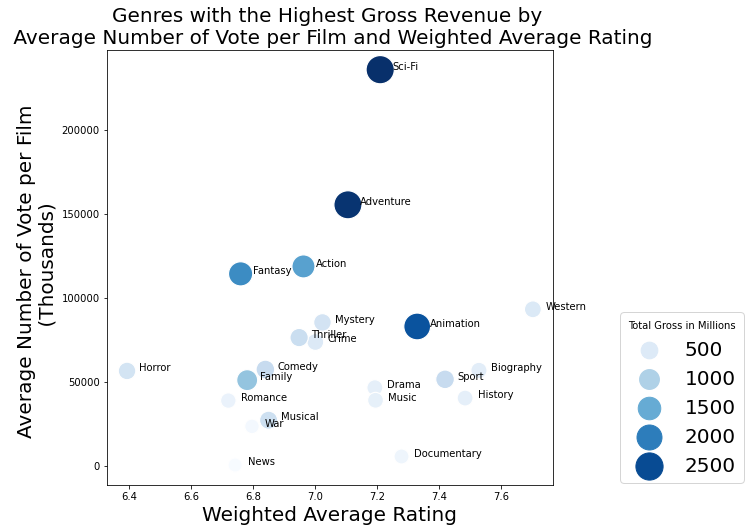

In [24]:
#plot scatter plot: weighted average vs avg number of votes vs avg total gross
plt.figure(figsize = (8,8))
p= sns.scatterplot(data=genre_to_gross,
                x='wavg_rating', 
                y='avgnumvotes', 
                size='total_gross_scaled',
                sizes=(200, 800), hue= 'total_gross_scaled', palette="Blues")
plt.legend(title='Total Gross in Millions', bbox_to_anchor=(1.45, -0.02), loc="lower right", frameon=True, fontsize =20)
plt.xlabel("Weighted Average Rating", size=20)
plt.ylabel('Average Number of Vote per Film \n (Thousands)', size=20)
plt.title('Genres with the Highest Gross Revenue by \n Average Number of Vote per Film and Weighted Average Rating', size=20)
#sns.set(font_scale =1.15)
plt.rcParams["axes.labelsize"] = 20
for i, txt in enumerate(genre_to_gross['genres']):
    plt.annotate(txt,(genre_to_gross['wavg_rating'][i]+.04, genre_to_gross['avgnumvotes'][i]-.06), size='medium', color='black',annotation_clip = False)

### Top 10 Earning Genres

***

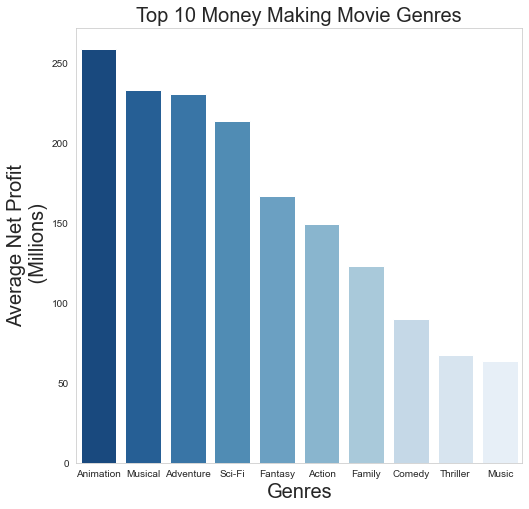

In [25]:
sns.set_style("whitegrid", {'axes.grid' : False})
#plot scatter plot: weighted average vs avg number of votes vs avg total gross
plt.figure(figsize = (8,8))
sns.barplot(data=top_earning_genres, x='genres',y= 'earnings_in_millions', palette="Blues_r")
plt.xlabel('Genres', size=20)
plt.ylabel('Average Net Profit\n (Millions)', size=20)
plt.title('Top 10 Money Making Movie Genres', size=20);

### Rotten Tomatoes, Genre x Rating Comparison

***

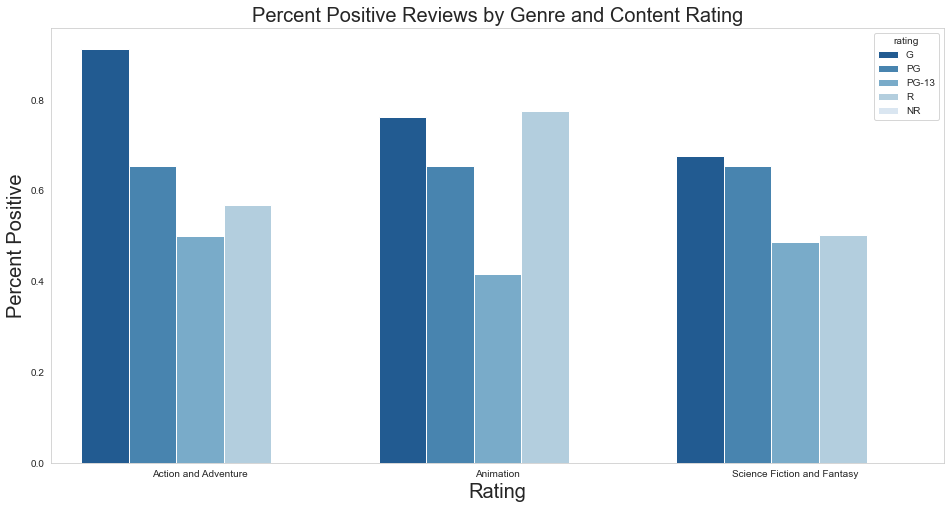

In [26]:
# Aggregate RT data and drop NR ratings due to small sample size
df = dp.merge_rt_data(focus='combined_popularity')
# Select the highest amount 
mask = (df['genre'].isin(['Action and Adventure', 'Science Fiction and Fantasy', 'Animation'])) & (df['rating'] != 'NR')
subset= df[mask]
plt.figure(figsize=(16,8))

seaborn_grid = sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(data=subset, x='genre',y= 'percent_positive', hue="rating", palette="Blues_r")
plt.xlabel('Rating', size=20)
plt.ylabel('Percent Positive', size=20)
plt.title('Percent Positive Reviews by Genre and Content Rating', size=20);

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***